In [2]:
%matplotlib inline

import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as meter

import statsmodels.api as sm

In [3]:
warnings.filterwarnings('ignore')

DF=pd.read_csv('diabetes.csv')
DF.info()
DF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Data Balancing
500 non-diabetic observations
268 diabetic observations

This degree of stratification should not be too problematic for logistic glm's.

In [4]:
temp=DF['Outcome'].astype(object)
temp.describe()

count     768
unique      2
top         0
freq      500
Name: Outcome, dtype: int64

### Data Cleaning & Imputation

Values need to be imputed for zero values of **Glucose**, **BloodPressure**,**SkinThickness**, **BMI**. Imputation will be done for only these fields because zero values are non-sensical given the testing procedure and the clinical interpretation. The imputation will replace zero-valued entries with the mean value of the data without the outliers omitted. Mean value imputation is used because because a logistic glm will be fit to the data.

In [5]:
zero_entries=[]

for i in DF.columns:
    zero_entries=np.append(zero_entries,len(DF[DF[i]==0]))
    
zero_entries=pd.DataFrame({'Field':DF.columns,
                           'ZeroCount':zero_entries})
zero_entries

# Copy to transform into cleaned data
DF_clean=pd.DataFrame(DF,copy=True)

avg_glucose=np.mean(DF_clean[DF_clean['Glucose'] !=0]['Glucose'])
avg_bp=np.mean(DF_clean[DF_clean['BloodPressure'] !=0]['BloodPressure'])
avg_sk=np.mean(DF_clean[DF_clean['SkinThickness'] !=0]['SkinThickness'])
avg_bmi=np.mean(DF_clean[DF_clean['BMI']!=0]['BMI'])

for i in np.arange(0,DF_clean.shape[0]):
    if(DF_clean.loc[i,'Glucose']==0):
        DF_clean.loc[i,'Glucose']=avg_glucose
    if(DF_clean.loc[i,'BloodPressure']==0):
        DF_clean.loc[i,'BloodPressure']=avg_bp
    if(DF_clean.loc[i,'SkinThickness']==0):
        DF_clean.loc[i,'SkinThickness']=avg_sk
    if(DF_clean.loc[i,'BMI']==0):
        DF_clean.loc[i,'BMI']=avg_bmi

In [6]:
DF_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,79.799479,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,115.244002,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,30.500000,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Data Partitioning

In [7]:
X_main=DF_clean.drop('Outcome',axis=1)
y_main=DF['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X_main, y_main, test_size=0.4, random_state=1234)

print('Training Set Observations ' + str(len(y_train)))
print('Diabetic:nonDiabetic Proportion in Train Data ' + str(len(y_train[y_train==1])/len(y_train)))
print('')

print('Test Set Observations ' + str(len(y_test)))
print('Diabetic:nonDiabetic Proportion in Test Data ' + str(len(y_test[y_test==1])/len(y_test)))

Training Set Observations 460
Diabetic:nonDiabetic Proportion in Train Data 0.34782608695652173

Test Set Observations 308
Diabetic:nonDiabetic Proportion in Test Data 0.35064935064935066


### Feature Engineering - 1st Order Interactions

In [8]:
primary_vars=X_train.columns
for i in np.arange(0,8):
    for j in np.arange(i+1,8):
        col_name=primary_vars[i] + ':' +primary_vars[j]
        X_train.loc[:,(col_name)] = X_train.loc[:,(primary_vars[i])]*X_train.loc[:,(primary_vars[j])]
        X_test.loc[:,(col_name)] = X_test.loc[:,(primary_vars[i])]*X_test.loc[:,(primary_vars[j])]


### Data Visualization of Training Data - Main Effects

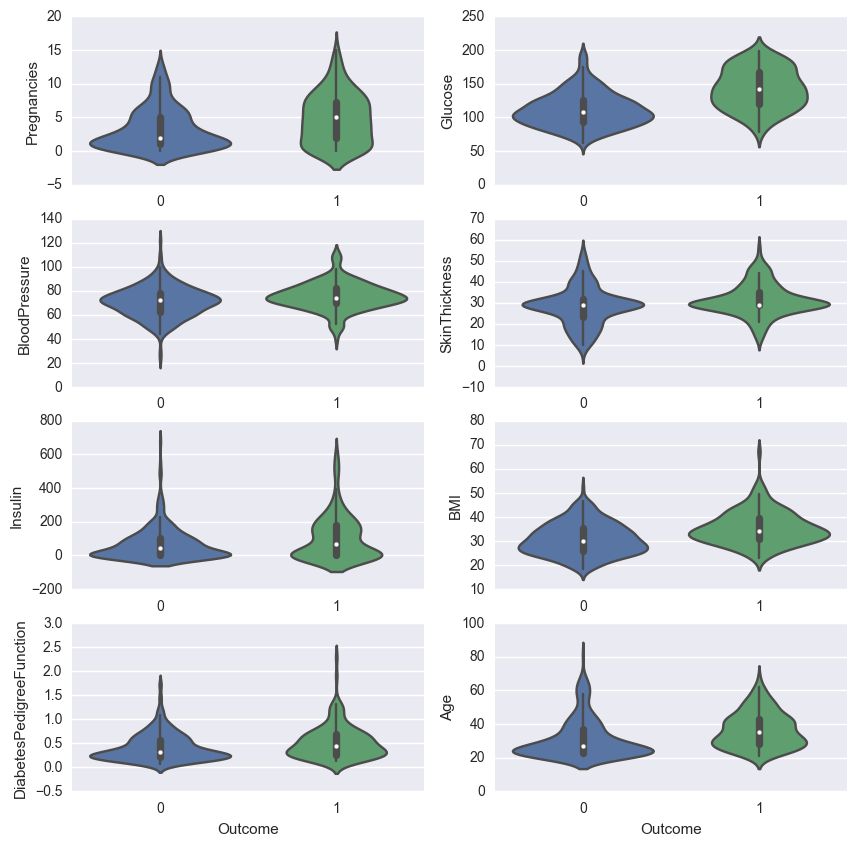

In [133]:
train = X_train.copy()
train['Outcome']=y_train

plt.figure(figsize=(10,10))

plt.subplot(4,2,1)
sns.violinplot(data=train, y='Pregnancies',x='Outcome')
plt.xlabel('')

plt.subplot(4,2,2)
sns.violinplot(data=train, y='Glucose',x='Outcome')
plt.xlabel('')

plt.subplot(4,2,3)
sns.violinplot(data=train, y='BloodPressure',x='Outcome')
plt.xlabel('')

plt.subplot(4,2,4)
sns.violinplot(data=train, y='SkinThickness',x='Outcome')
plt.xlabel('')

plt.subplot(4,2,5)
sns.violinplot(data=train, y='Insulin',x='Outcome')
plt.xlabel('')

plt.subplot(4,2,6)
sns.violinplot(data=train, y='BMI',x='Outcome')
plt.xlabel('')

plt.subplot(4,2,7)
sns.violinplot(data=train, y='DiabetesPedigreeFunction',x='Outcome')

plt.subplot(4,2,8)
sns.violinplot(data=train, y='Age',x='Outcome')

### Traditional Logistic GLM

In [169]:
logit_train_X=sm.add_constant(X_train,prepend=False)

logit_model = sm.GLM( y_train,logit_train_X,family=sm.families.Binomial())
logit_results=logit_model.fit()

print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:                  460
Model:                            GLM   Df Residuals:                      423
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -192.77
Date:                Wed, 22 Mar 2017   Deviance:                       385.54
Time:                        01:28:56   Pearson chi2:                     495.
No. Iterations:                     8                                         
                                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
Pregnancies                                1.5995      0.489      3.268    

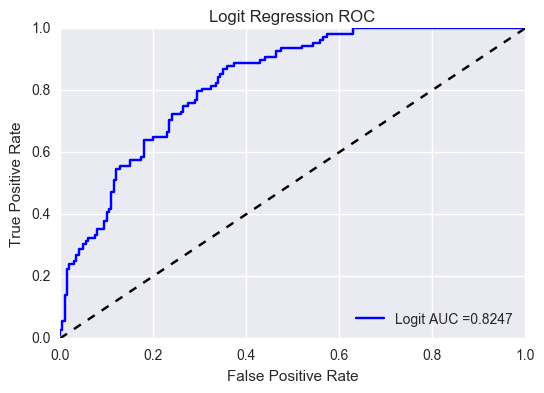

In [12]:
logit_test_X=sm.add_constant(X_test,prepend=False)
test_res=logit_results.predict(logit_test_X)

fpr_logit,tpr_logit,thresh_logit =meter.roc_curve(y_test,test_res)
auc_logit=meter.roc_auc_score(y_test,test_res)

plt.plot(fpr_logit,tpr_logit,'b',label='Logit AUC =%0.4f' %auc_logit)
plt.plot([0,1],[0,1],'k--')

plt.title('Logit Regression ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')


### Regularized Logistic Regression - Lasso & Ridge

In [79]:
param_reglog=dict(C=[0.001,0.01,0.1,1,10])

LR_l1 = LogisticRegression(C=1, penalty='l1', tol=0.01)
grid_l1=GridSearchCV(LR_l1,param_grid=param_reglog)
grid_l1_res=grid_l1.fit(X_train, y_train)

LR_l2 = LogisticRegression(C=1, penalty='l2', tol=0.01)
grid_l2=GridSearchCV(LR_l2,param_grid=param_reglog)
grid_l2_res=grid_l2.fit(X_train, y_train)


In [80]:
best_L1_model=pd.DataFrame(grid_l1_res.best_estimator_.coef_)
best_L1_model.columns=X_train.columns
best_L1_model['intercept']=grid_l1_res.best_estimator_.intercept_

best_L2_model=pd.DataFrame(grid_l2_res.best_estimator_.coef_)
best_L2_model.columns=[X_train.columns]
best_L2_model['intercept']=grid_l2_res.best_estimator_.intercept_


***Insignificant Variables:*** The L1 regularization reduced coefficients for 4 main effect and 2 interactions to zero.

In [170]:
temp = (best_L1_model==0).values
print('L1 Regularized Logistic GLM: Insigificant Predictors')
print(X_train.columns[temp[0,0:-1]].values)
print('')

L1 Regularized Logistic GLM: Insigificant Predictors
['Pregnancies' 'Glucose' 'DiabetesPedigreeFunction' 'Age'
 'Pregnancies:DiabetesPedigreeFunction' 'BMI:DiabetesPedigreeFunction']



### ROC Parameters

In [126]:
L1_pred=grid_l1_res.best_estimator_.predict_proba(X_test)
L2_pred=grid_l2_res.best_estimator_.predict_proba(X_test)

fpr_l1,tpr_l1,thresh_l1 = meter.roc_curve(y_test.values,L1_pred[:,1])
fpr_l2,tpr_l2,thresh_l2 = meter.roc_curve(y_test.values,L2_pred[:,1])

auc_l1=meter.roc_auc_score(y_test,L1_pred[:,1])
auc_l2=meter.roc_auc_score(y_test,L2_pred[:,1])

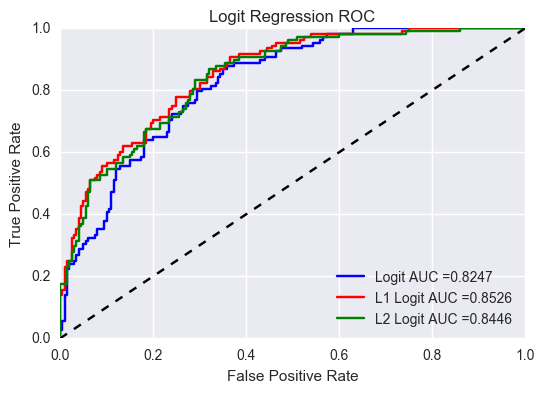

In [127]:
plt.plot(fpr_logit,tpr_logit,'b',label='Logit AUC =%0.4f' %auc_logit)
plt.plot(fpr_l1,tpr_l1,'r',label='L1 Logit AUC =%0.4f' %auc_l1)
plt.plot(fpr_l2,tpr_l2,'g',label='L2 Logit AUC =%0.4f' %auc_l2)
plt.plot([0,1],[0,1],'k--')

plt.title('Logit Regression ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
